
Case study: US daily Covid 19 data

# Time Series Forecasting Mini project 

## Project Member 

### Bharath K M 
### Marimuthu S
### Santhosh Kumar G

## Importing required libraries

In [142]:
import pandas                             as      pd
import numpy                              as      np
import matplotlib.pyplot                  as      plt
import seaborn                            as      sns
from   IPython.display                    import  display
from   pylab                              import  rcParams 
from   sklearn.metrics                    import  mean_squared_error
from   datetime                           import  datetime, timedelta
from statsmodels.tsa.stattools            import  adfuller
from statsmodels.tsa.stattools            import  pacf
from statsmodels.tsa.stattools            import  acf
from statsmodels.graphics.tsaplots        import  plot_pacf
from statsmodels.graphics.tsaplots        import  plot_acf
from statsmodels.graphics.gofplots        import  qqplot
from statsmodels.tsa.seasonal             import  seasonal_decompose, STL
from statsmodels.tsa.arima_model          import  ARIMA
from statsmodels.tsa.statespace.sarimax   import  SARIMAX
from statsmodels.tsa.api                  import  ExponentialSmoothing, SimpleExpSmoothing, Holt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Import the data

### Data is collected for the period of 17th March 2020 to 06th December 2020. Data is collected on daily basis for Positive cases, Hospitalized and Death count

In [51]:
df_covid = pd.read_csv('us_covid19_daily.csv')

In [52]:
df_covid

,Date,Positive,Hospitalized,Death
0,17-03-2020,10021,325,124
1,18-03-2020,13385,416,155
2,19-03-2020,18085,617,203
3,20-03-2020,24197,1042,273
4,21-03-2020,31013,1492,335
...,...,...,...,...
260,02-12-2020,13711156,100322,264522
261,03-12-2020,13921360,100755,267228
262,04-12-2020,14146191,101276,269791
263,05-12-2020,14357264,101190,272236


### Convert the data into time series data

In [53]:
df_covid['Date'] = pd.to_datetime(df_covid['Date'],infer_datetime_format=True) #convert from string to datetime
df_covid = df_covid.set_index(['Date'])
df_covid

,Positive,Hospitalized,Death
Date,,,
2020-03-17,10021,325,124
2020-03-18,13385,416,155
2020-03-19,18085,617,203
2020-03-20,24197,1042,273
2020-03-21,31013,1492,335
...,...,...,...
2020-12-02,13711156,100322,264522
2020-12-03,13921360,100755,267228
2020-12-04,14146191,101276,269791


### For this case study, we will build time series model to forecast the Hospitalized count

### Plot the variable 'hospitalized'

Text(0, 0.5, 'Hospitalized')

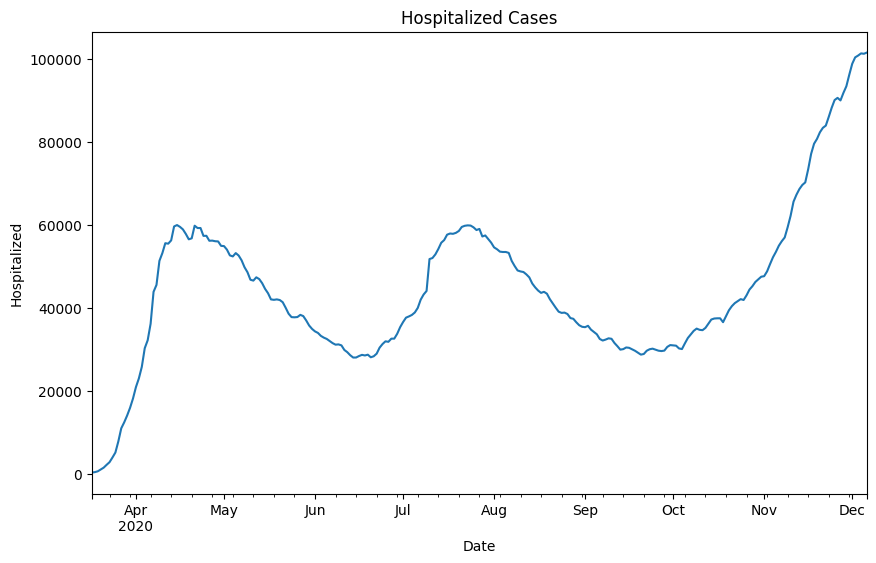

In [59]:
df_covid['Hospitalized'].plot(figsize=(10,6),title='Hospitalized Cases')
plt.ylabel('Hospitalized')

**From the above plot I would say there are outliers present in the Hospitalized column but which should not be removed from the dataset**

## Perform Exploratory Data Analysis

In [55]:
df_covid.isnull().sum()

Positive        0
Hospitalized    0
Death           0
dtype: int64

### Plot monthwise distribution

**As per above output it was clear that we don't have any null values in our dataset**

Text(0, 0.5, 'Positive')

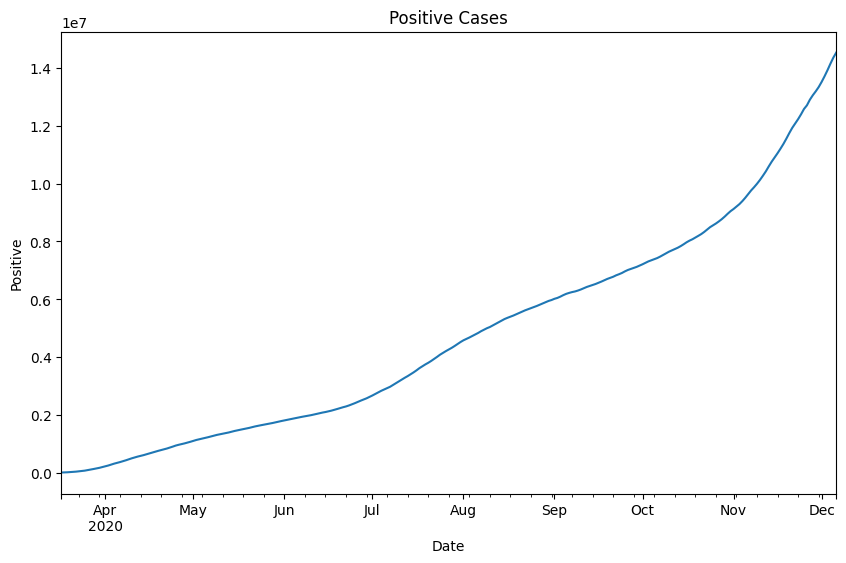

In [60]:
### Plotting positive cases 

df_covid['Positive'].plot(figsize=(10,6),title='Positive Cases')
plt.ylabel('Positive')

Text(0, 0.5, 'Death')

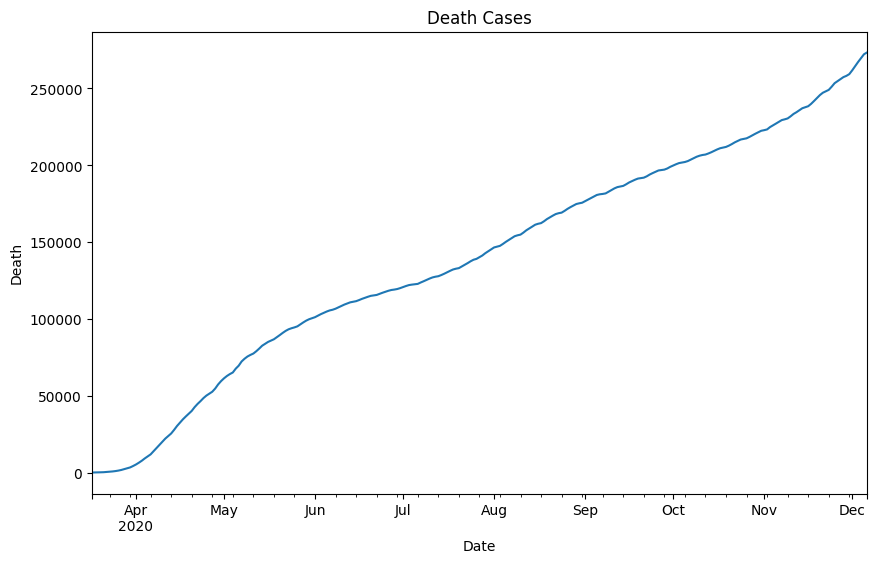

In [61]:
### Plotting Death cases 
df_covid['Death'].plot(figsize=(10,6),title='Death Cases')
plt.ylabel('Death')

## Decompose the time series

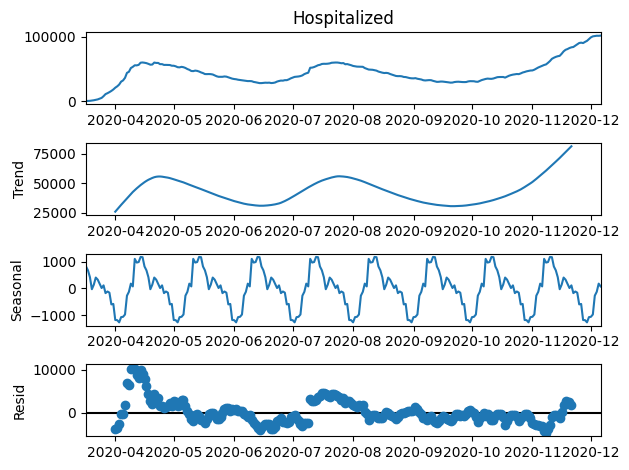

In [66]:
decomposition = seasonal_decompose(df_covid["Hospitalized"],model='additive', period = 30)
decomposition.plot();

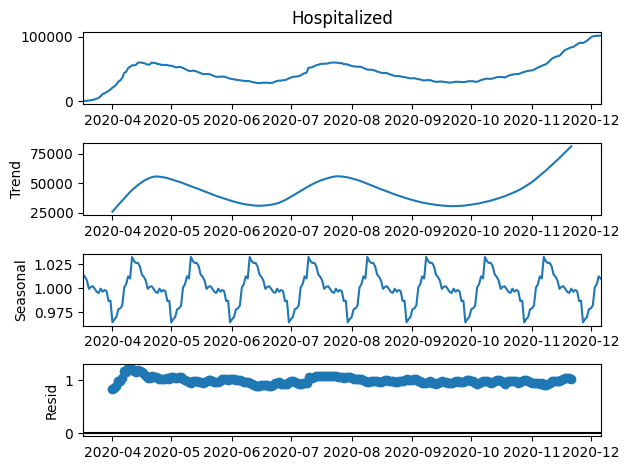

In [65]:
decomposition = seasonal_decompose(df_covid["Hospitalized"],model='multiplicative', period = 30)
decomposition.plot();

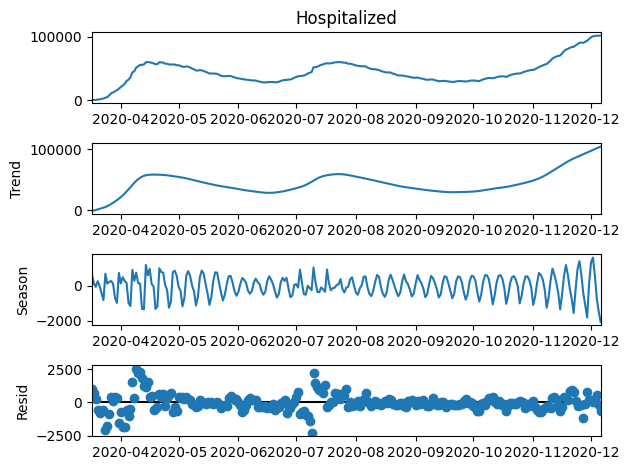

In [70]:
decomposition = STL(df_covid["Hospitalized"]).fit()
decomposition.plot();

## Check for stationarity in the data

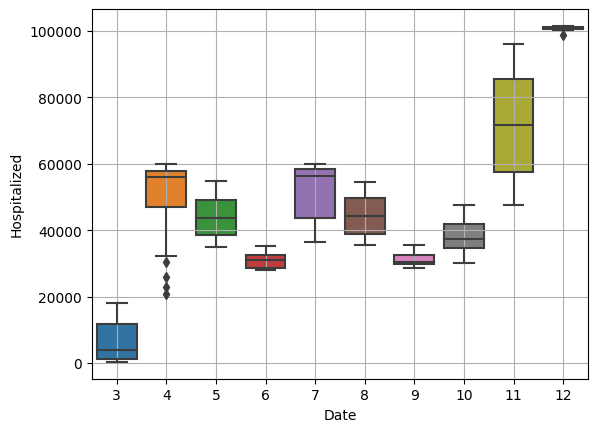

In [76]:
sns.boxplot(x=df_covid.index.month,y=df_covid['Hospitalized'])
plt.grid();

In [79]:
observations= df_covid["Hospitalized"].values
test_result = adfuller(observations)

In [80]:
test_result

(-1.6387257227470495,
 0.46292671711887773,
 16,
 248,
 {'1%': -3.4569962781990573,
  '5%': -2.8732659015936024,
  '10%': -2.573018897632674},
 4101.584279516279)

In [95]:
print('ADF Statistic: %f' % test_result[0])
print('p-value: %f' % test_result[1])
print('Critical Values:')
for key, value in test_result[4].items():
	print('\t%s: %.5f' % (key, value))

ADF Statistic: -3.155128
p-value: 0.022733
Critical Values:
	1%: -3.45711
	5%: -2.87331
	10%: -2.57304


## applying differencing

In [82]:
df_diff = df_covid["Hospitalized"].diff(periods=1).dropna()
observations= df_diff.values
test_result = adfuller(observations)
test_result

(-3.1551279027958765,
 0.022733461203747,
 16,
 247,
 {'1%': -3.457105309726321,
  '5%': -2.873313676101283,
  '10%': -2.5730443824681606},
 4086.8057125045957)

In [87]:
print('ADF Statistic: %f' % test_result[0])
print('p-value: %f' % test_result[1])
print('Critical Values:')
for key, value in test_result[4].items():
	print('\t%s: %.5f' % (key, value))

ADF Statistic: -3.155128
p-value: 0.022733
Critical Values:
	1%: -3.45711
	5%: -2.87331
	10%: -2.57304


## Let's plot rolling mean and std deviation

<AxesSubplot: xlabel='Date'>

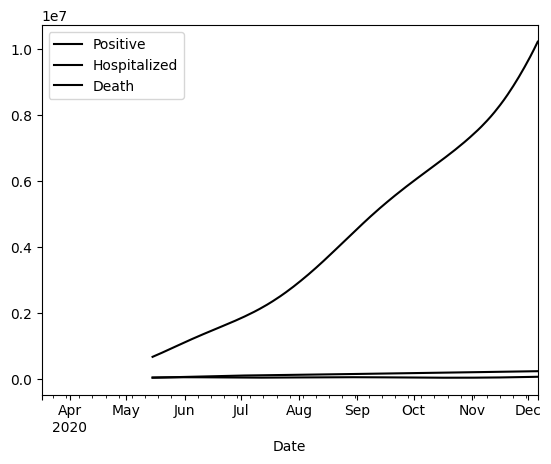

In [90]:
# calculate a 60 day rolling mean and plot
df_covid.rolling(window=60).mean().plot(style='k')

<AxesSubplot: xlabel='Date'>

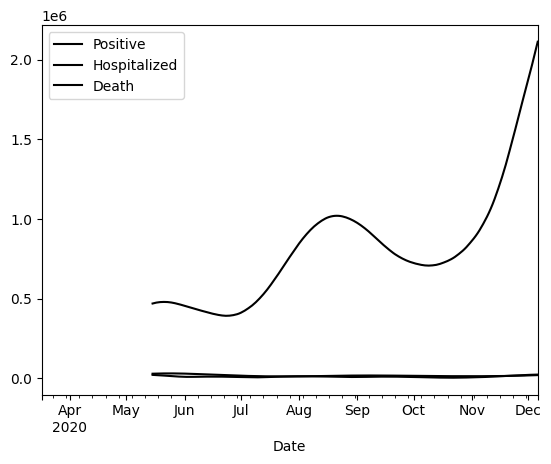

In [94]:
# calculate a 60 day rolling std and plot
df_covid.rolling(window=60).std().plot(style='k')

## Perform statistical test to confirm the stationarity

## Plot the ACF and PACF plots for the series

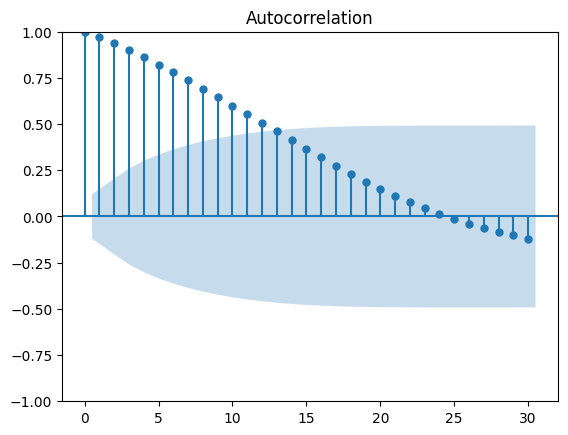

In [83]:
plot_acf(df_covid["Hospitalized"],lags=30);

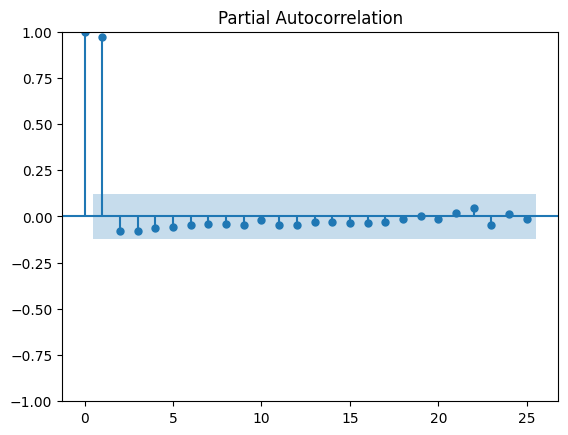

In [84]:
plot_pacf(df_covid["Hospitalized"]);

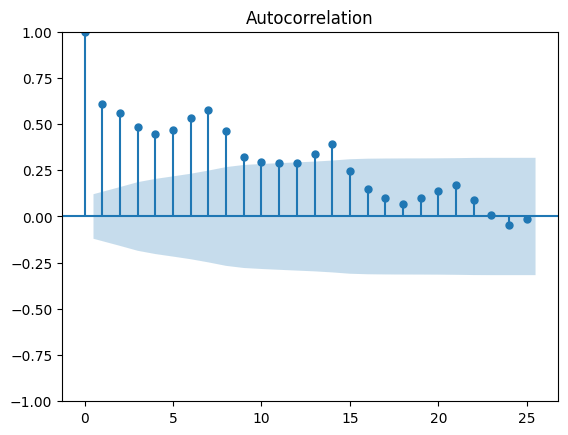

In [85]:
plot_acf(df_diff);

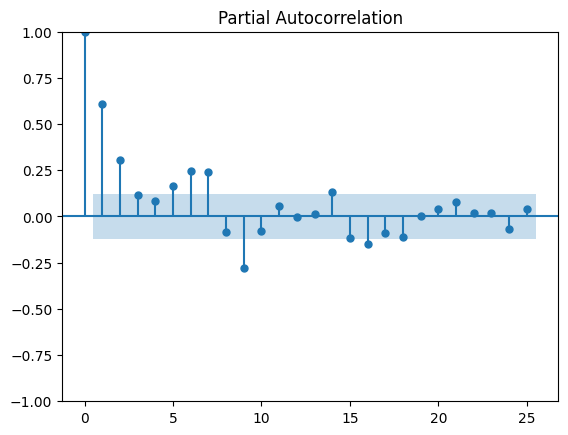

In [86]:
plot_pacf(df_diff);

### ACF plot is clearly showing, time series observations are heavily impacted by past values. While PACF is showing limited number of spikes before cut-off

## Split the series into training and testing sets

In [104]:
train = df_covid["Hospitalized"].loc[:'30-10-2020']
test = df_covid["Hospitalized"].loc['30-10-2020':]

In [105]:
train_data = pd.DataFrame(train)
train_data.head(5)

,Hospitalized
Date,
2020-03-17,325
2020-03-18,416
2020-03-19,617
2020-03-20,1042
2020-03-21,1492


In [106]:
test_data = pd.DataFrame(test)
test_data.head(5)

,Hospitalized
Date,
2020-10-30,46856
2020-10-31,47486
2020-11-01,47615
2020-11-02,48773
2020-11-03,50512


### We will build the Holt forecasting model and Holt-Winter forecasting model.

# Double Exponential Smoothing / Holt's linear Method

In [146]:
model_DES = Holt(train_data,exponential=True, initialization_method='estimated')

#### training the double exponential model

In [147]:
model_DES_fit1 = model_DES.fit(optimized=True)

In [148]:
model_DES_fit1.summary()

Dep. Variable:,Hospitalized,No. Observations:,228
Model:,Holt,SSE,56472580129562558128428066508197306415710208.000
Optimized:,True,AIC,21739.360
Trend:,Multiplicative,BIC,21753.078
Seasonal:,None,AICC,21739.740
Seasonal Periods:,None,Date:,"Thu, 06 Apr 2023"
Box-Cox:,False,Time:,17:42:50
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9478571,alpha,True
smoothing_trend,0.4623693,beta,True


#### Predicting forecast

In [174]:
DES_predict1 = model_DES_fit1.forecast(steps=len(test))

array([47730.05240245, 48600.70510847, 49487.2395514 , 50389.94543292,
       51309.11773924, 52245.05683745, 53198.06857371, 54168.46437316,
       55156.56134171, 56162.68236966, 57187.1562372 , 58230.31772187,
       59292.50770795, 60374.07329786, 61475.36792555, 62596.75147206,
       63738.59038306, 64901.25778865, 66085.13362523, 67290.60475971,
       68518.06511593, 69767.91580332, 71040.56524807, 72336.42932651,
       73655.93150108, 74999.50295864, 76367.58275145, 77760.61794056,
       79179.06374199, 80623.38367539, 82094.0497156 , 83591.54244682,
       85116.35121967, 86668.97431112, 88249.91908729, 89859.70216928,
       91498.84960193, 93167.89702581])

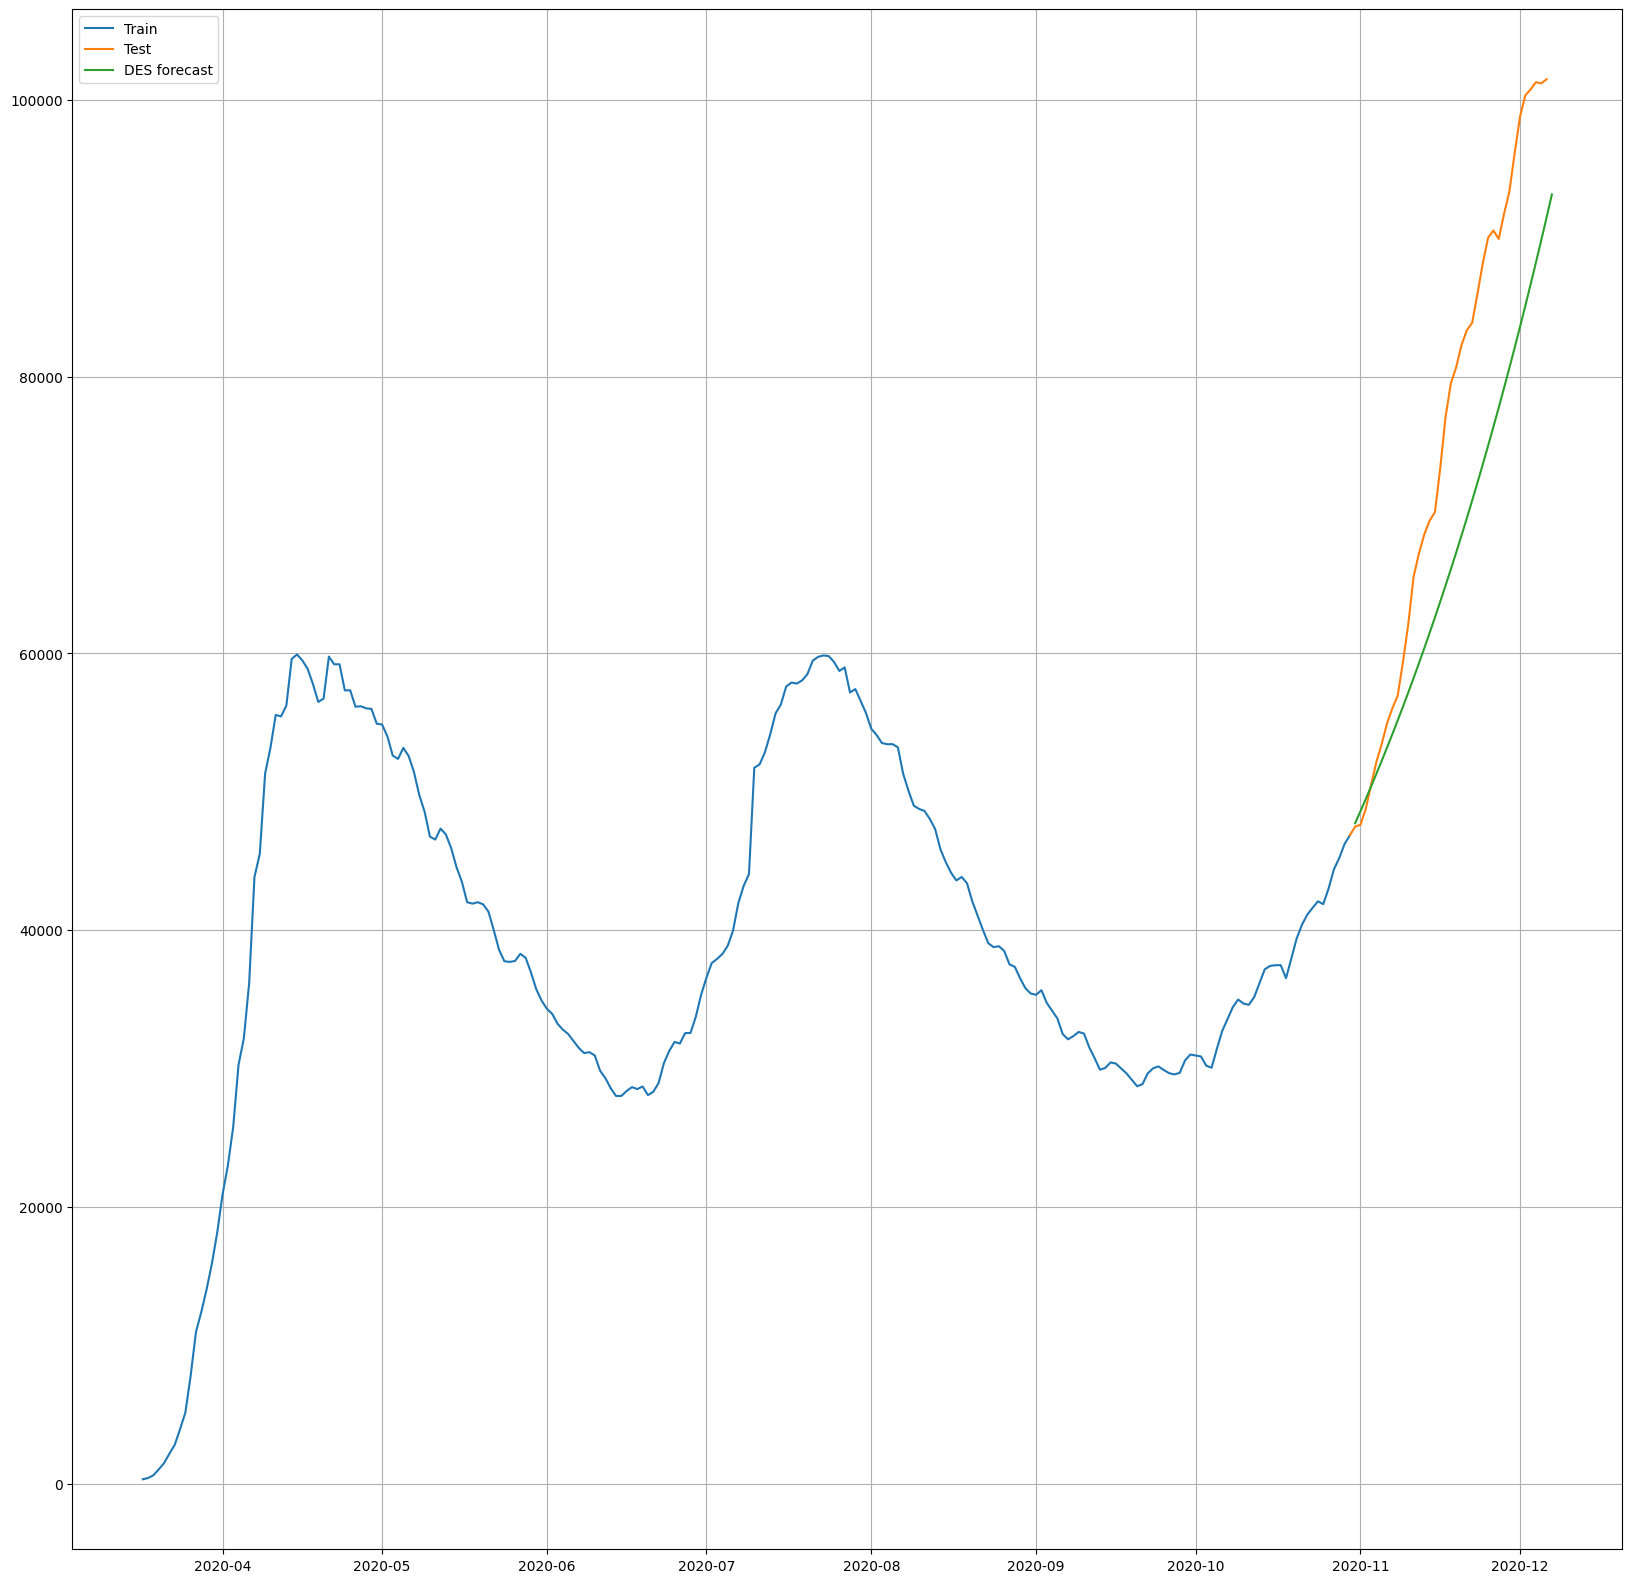

In [150]:
fig = plt.figure(figsize=(20, 20))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')

plt.plot(DES_predict1, label='DES forecast')
plt.legend(loc='best')
plt.grid()
plt.show()

# Triple Exponential Smoothing / Holt-Winters Method

#### lets build model using 'additive' seasonality

In [151]:
model_TES_add = ExponentialSmoothing(train_data,trend='additive',seasonal='additive',initialization_method='estimated')

#### training the model

In [152]:
model_TES_add = model_TES_add.fit(optimized=True)

In [153]:
model_TES_add.summary()

Dep. Variable:,Hospitalized,No. Observations:,228
Model:,ExponentialSmoothing,SSE,189761542.315
Optimized:,True,AIC,3130.081
Trend:,Additive,BIC,3167.804
Seasonal:,Additive,AICC,3131.782
Seasonal Periods:,7,Date:,"Thu, 06 Apr 2023"
Box-Cox:,False,Time:,17:43:22
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8340960,alpha,True
smoothing_trend,0.3761838,beta,True


#### predicting forecast

In [154]:
TES_add_predict =  model_TES_add.forecast(len(test_data))

#### lets plot foecast results

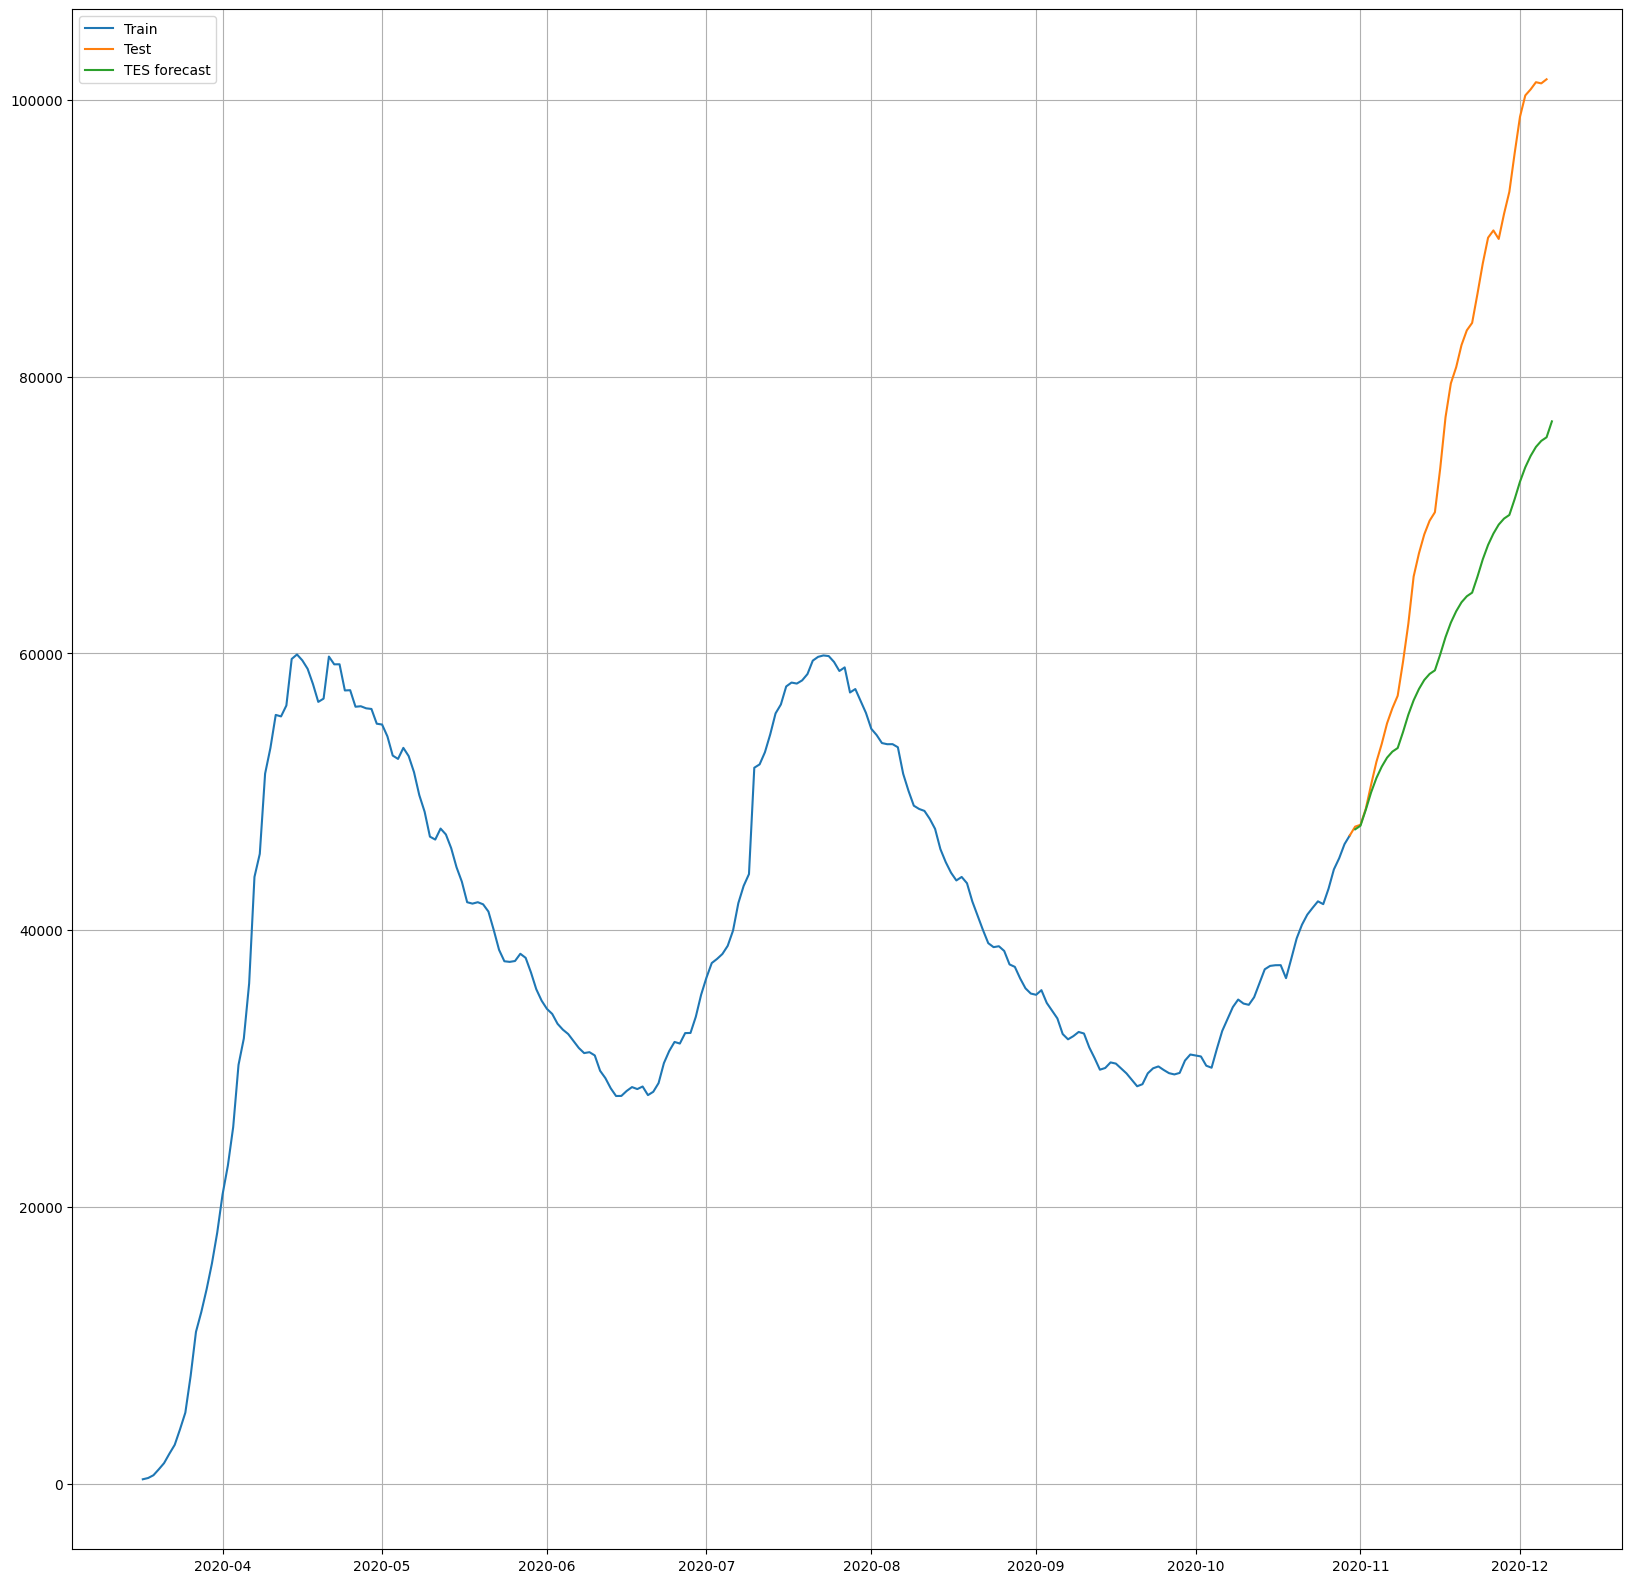

In [155]:
fig = plt.figure(figsize=(20, 20))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')

plt.plot(TES_add_predict, label='TES forecast')
plt.legend(loc='best')
plt.grid()

## lets build model uaing 'multiplicative' forecast

In [158]:
model_TES_mul = ExponentialSmoothing(train_data,trend='multiplicative',seasonal='multiplicative',initialization_method='estimated')

In [159]:
model_TES_mul = model_TES_mul.fit(optimized=True)

In [160]:
model_TES_mul.summary()

Dep. Variable:,Hospitalized,No. Observations:,228
Model:,ExponentialSmoothing,SSE,109869637180587923060728150334281742366638681391385854847455382732800.000
Optimized:,True,AIC,34504.849
Trend:,Multiplicative,BIC,34542.572
Seasonal:,Multiplicative,AICC,34506.550
Seasonal Periods:,7,Date:,"Thu, 06 Apr 2023"
Box-Cox:,False,Time:,17:46:04
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8182143,alpha,True
smoothing_trend,0.4405769,beta,True


In [161]:
#### predicting forecast
TES_mul_predict =  model_TES_mul.forecast(len(test))

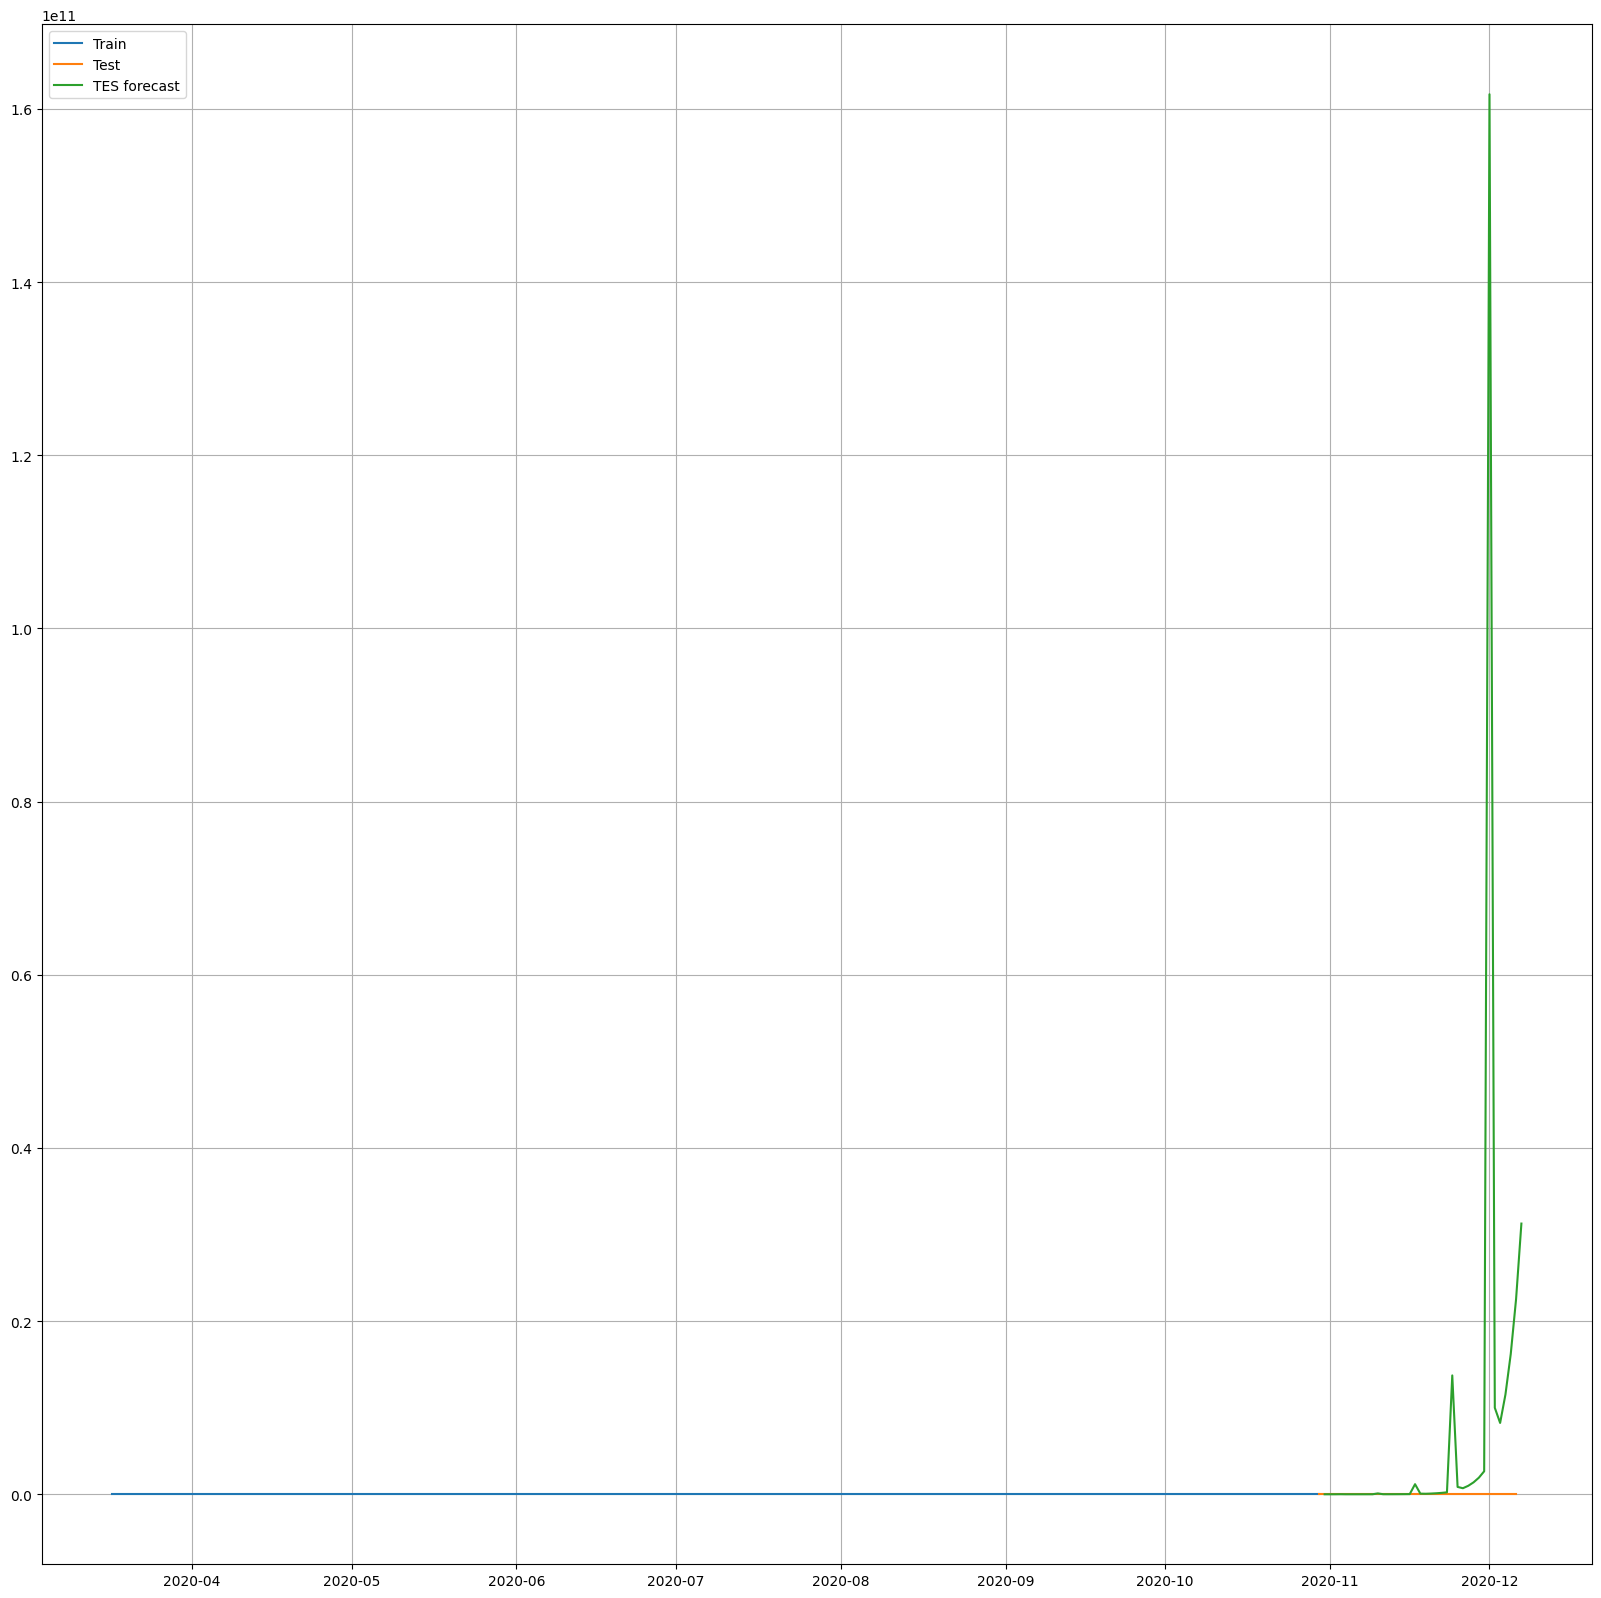

In [162]:
fig = plt.figure(figsize=(20, 20))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(TES_mul_predict, label='TES forecast')
plt.legend(loc='best')
plt.grid()

### Plot the model predictions and find the RMSE and MAPE value. 

## Evaluating Model Performance

### Double Exponential Smoothing 

In [175]:
mean_squared_error(test_data["Hospitalized"].values,DES_predict1.values,squared=False)

9196.47083050614

In [176]:
def MAPE(y_true, y_pred):
    return np.mean((np.abs(y_true-y_pred))/(y_true))*100

In [177]:
MAPE(test_data["Hospitalized"],DES_predict1)

10.76059656980832

## Triple Exponential smoothing (Additive model evaluation)

In [156]:
mean_squared_error(test_data["Hospitalized"].values,TES_add_predict.values,squared=False)

16262.10368882353

In [144]:
def MAPE(y_true, y_pred):
    return np.mean((np.abs(y_true-y_pred))/(y_true))*100

In [157]:
MAPE(test_data["Hospitalized"],TES_add_predict)

16.80449617264712

## Triple Exponential Smoothing (Multiplicative model evaluation)

In [163]:
mean_squared_error(test_data["Hospitalized"].values,TES_mul_predict.values,squared=False)

27337865015.120583

In [164]:
MAPE(test_data["Hospitalized"],TES_mul_predict)

6993646.599850103

### Calculate and plot the residuals.

### Calculating Double Exponential Smoothing Residuals

In [182]:
DES_residuals = test_data.Hospitalized - DES_predict1

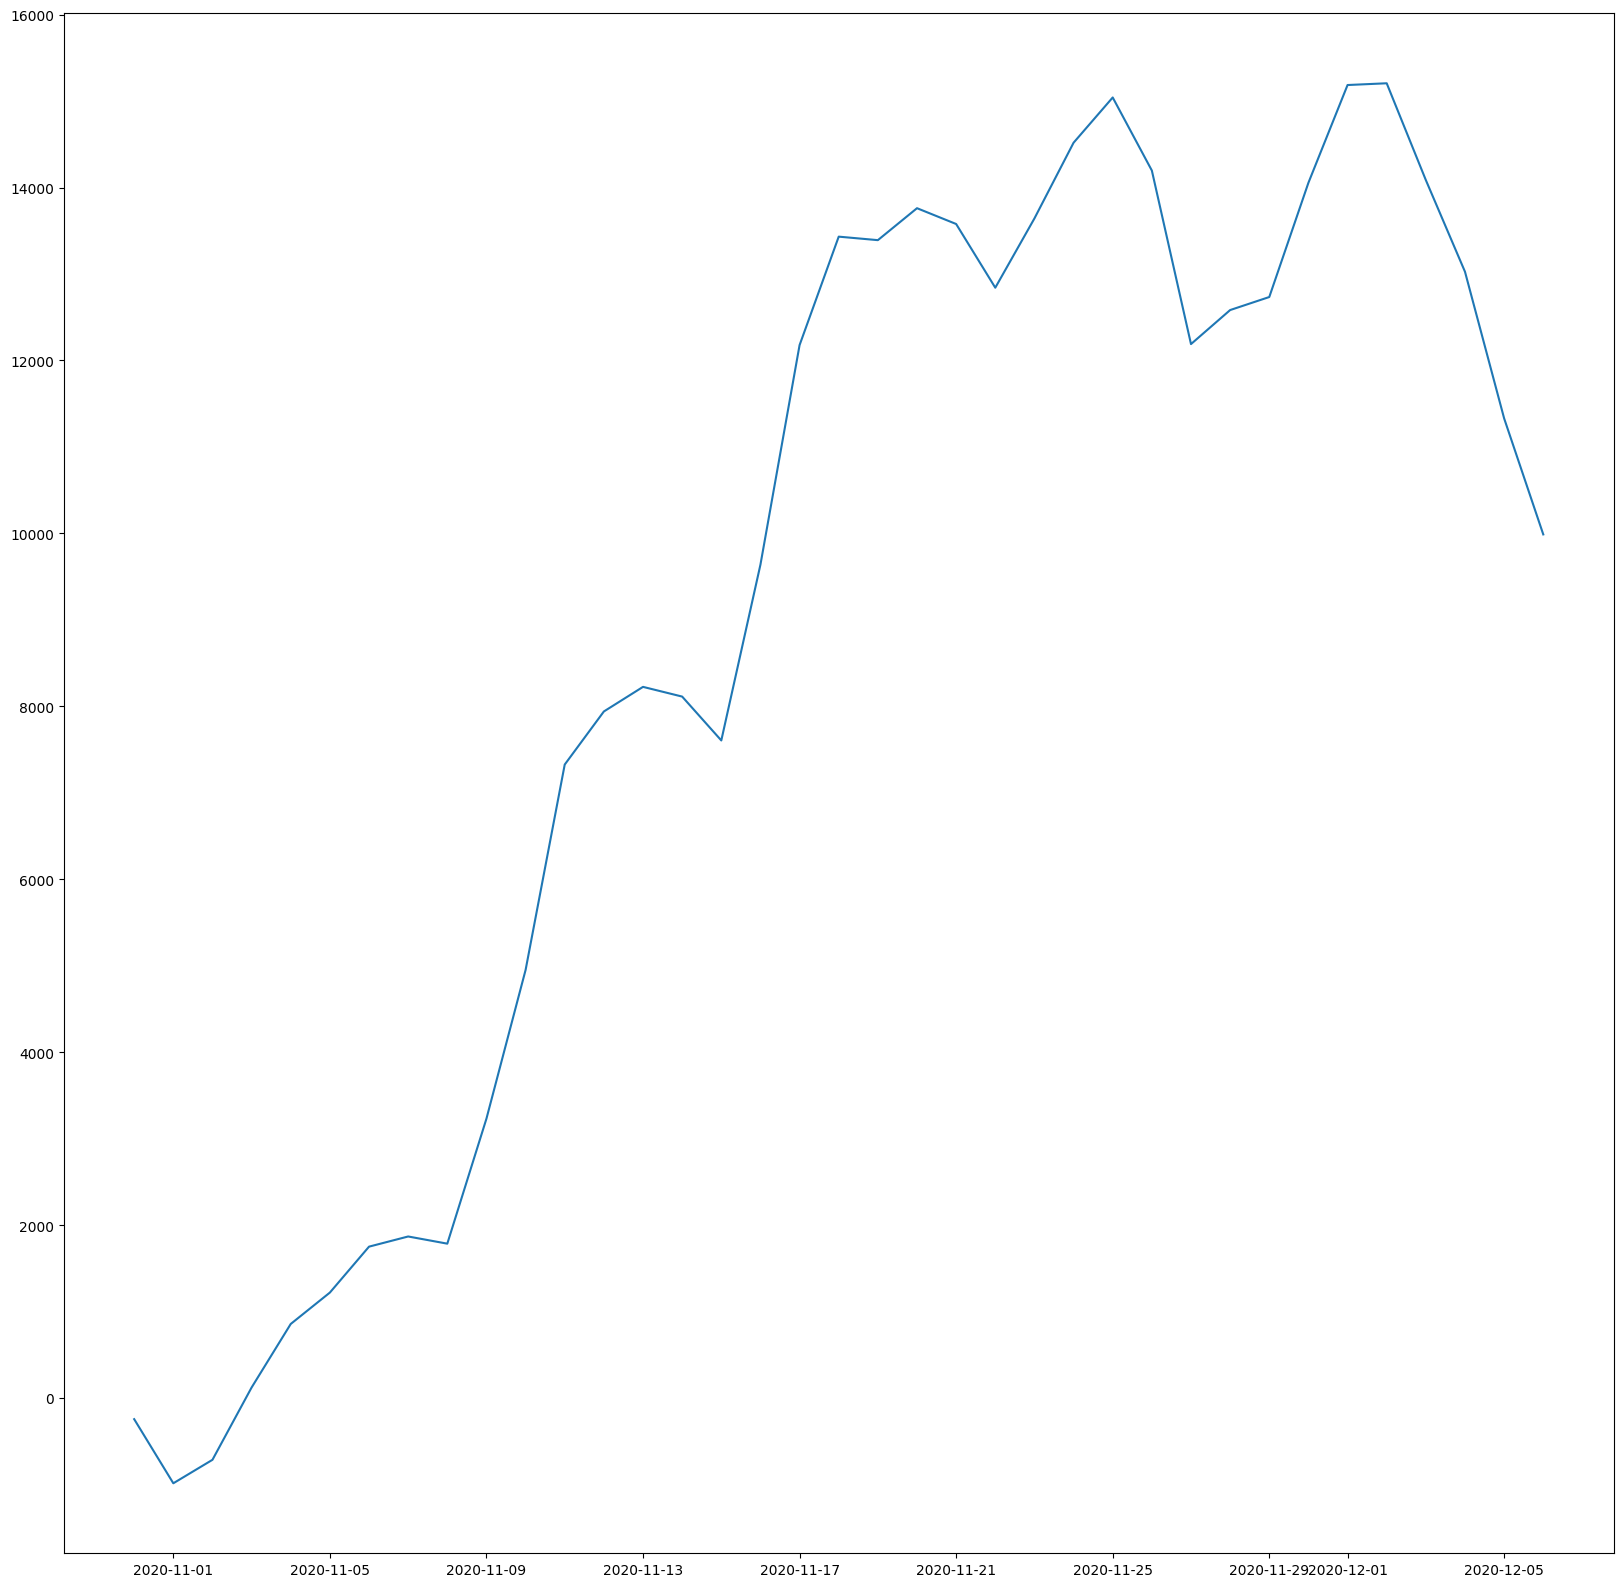

In [179]:
fig = plt.figure(figsize=(20, 20))
plt.plot(DES_residuals)
plt.show()

### Calculating Triple exponential Additive Residual

In [166]:
TES_Additive_residuals = test_data.Hospitalized - TES_add_predict

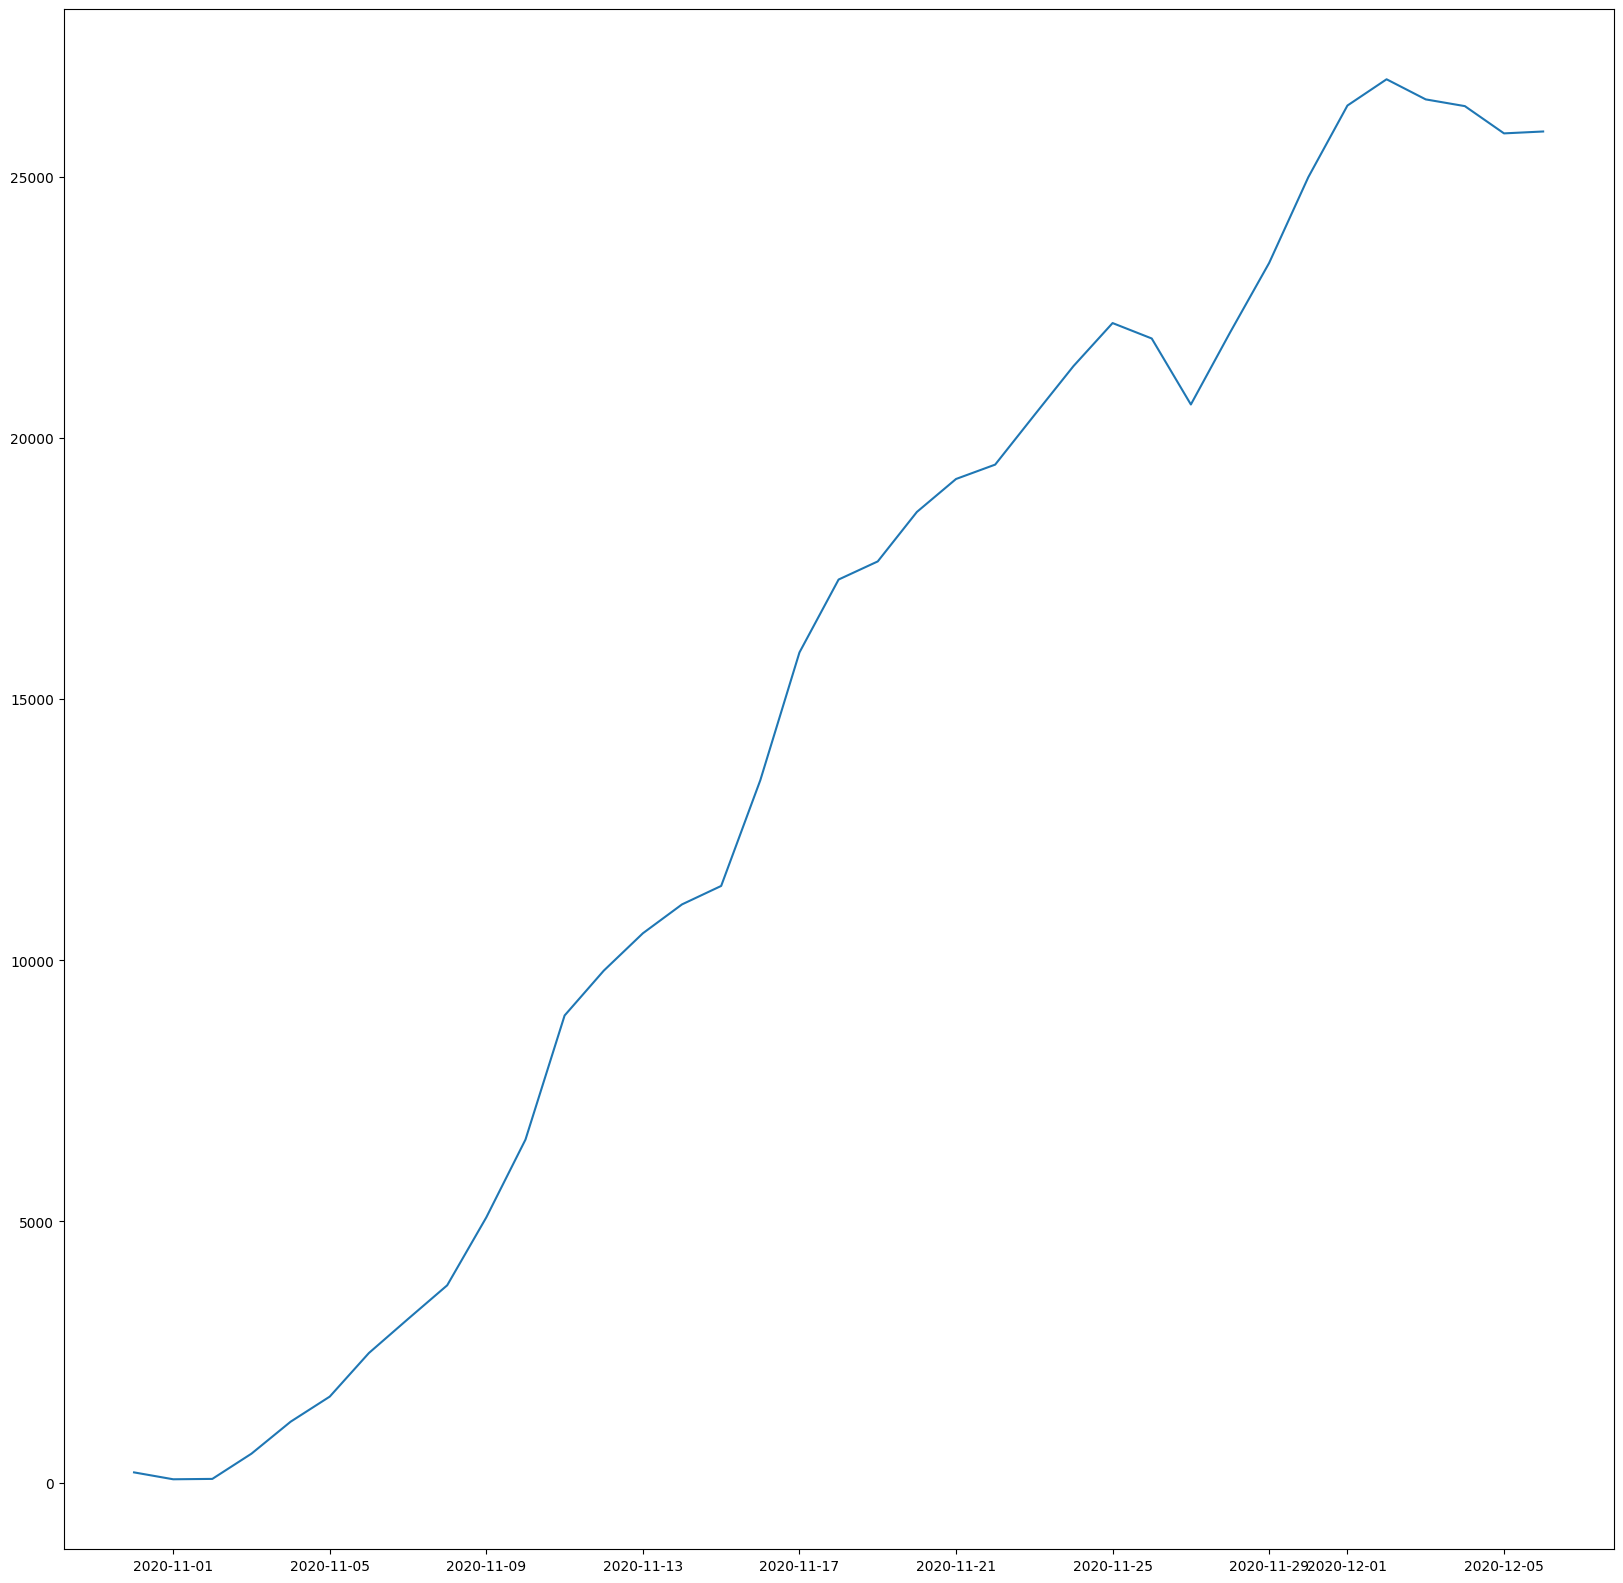

In [168]:
fig = plt.figure(figsize=(20, 20))
plt.plot(TES_Additive_residuals)
plt.show()

### Calculating Triple Exponential Multiplicative Residuals

In [169]:
TES_Multiplicative_residuals = test_data.Hospitalized - TES_mul_predict

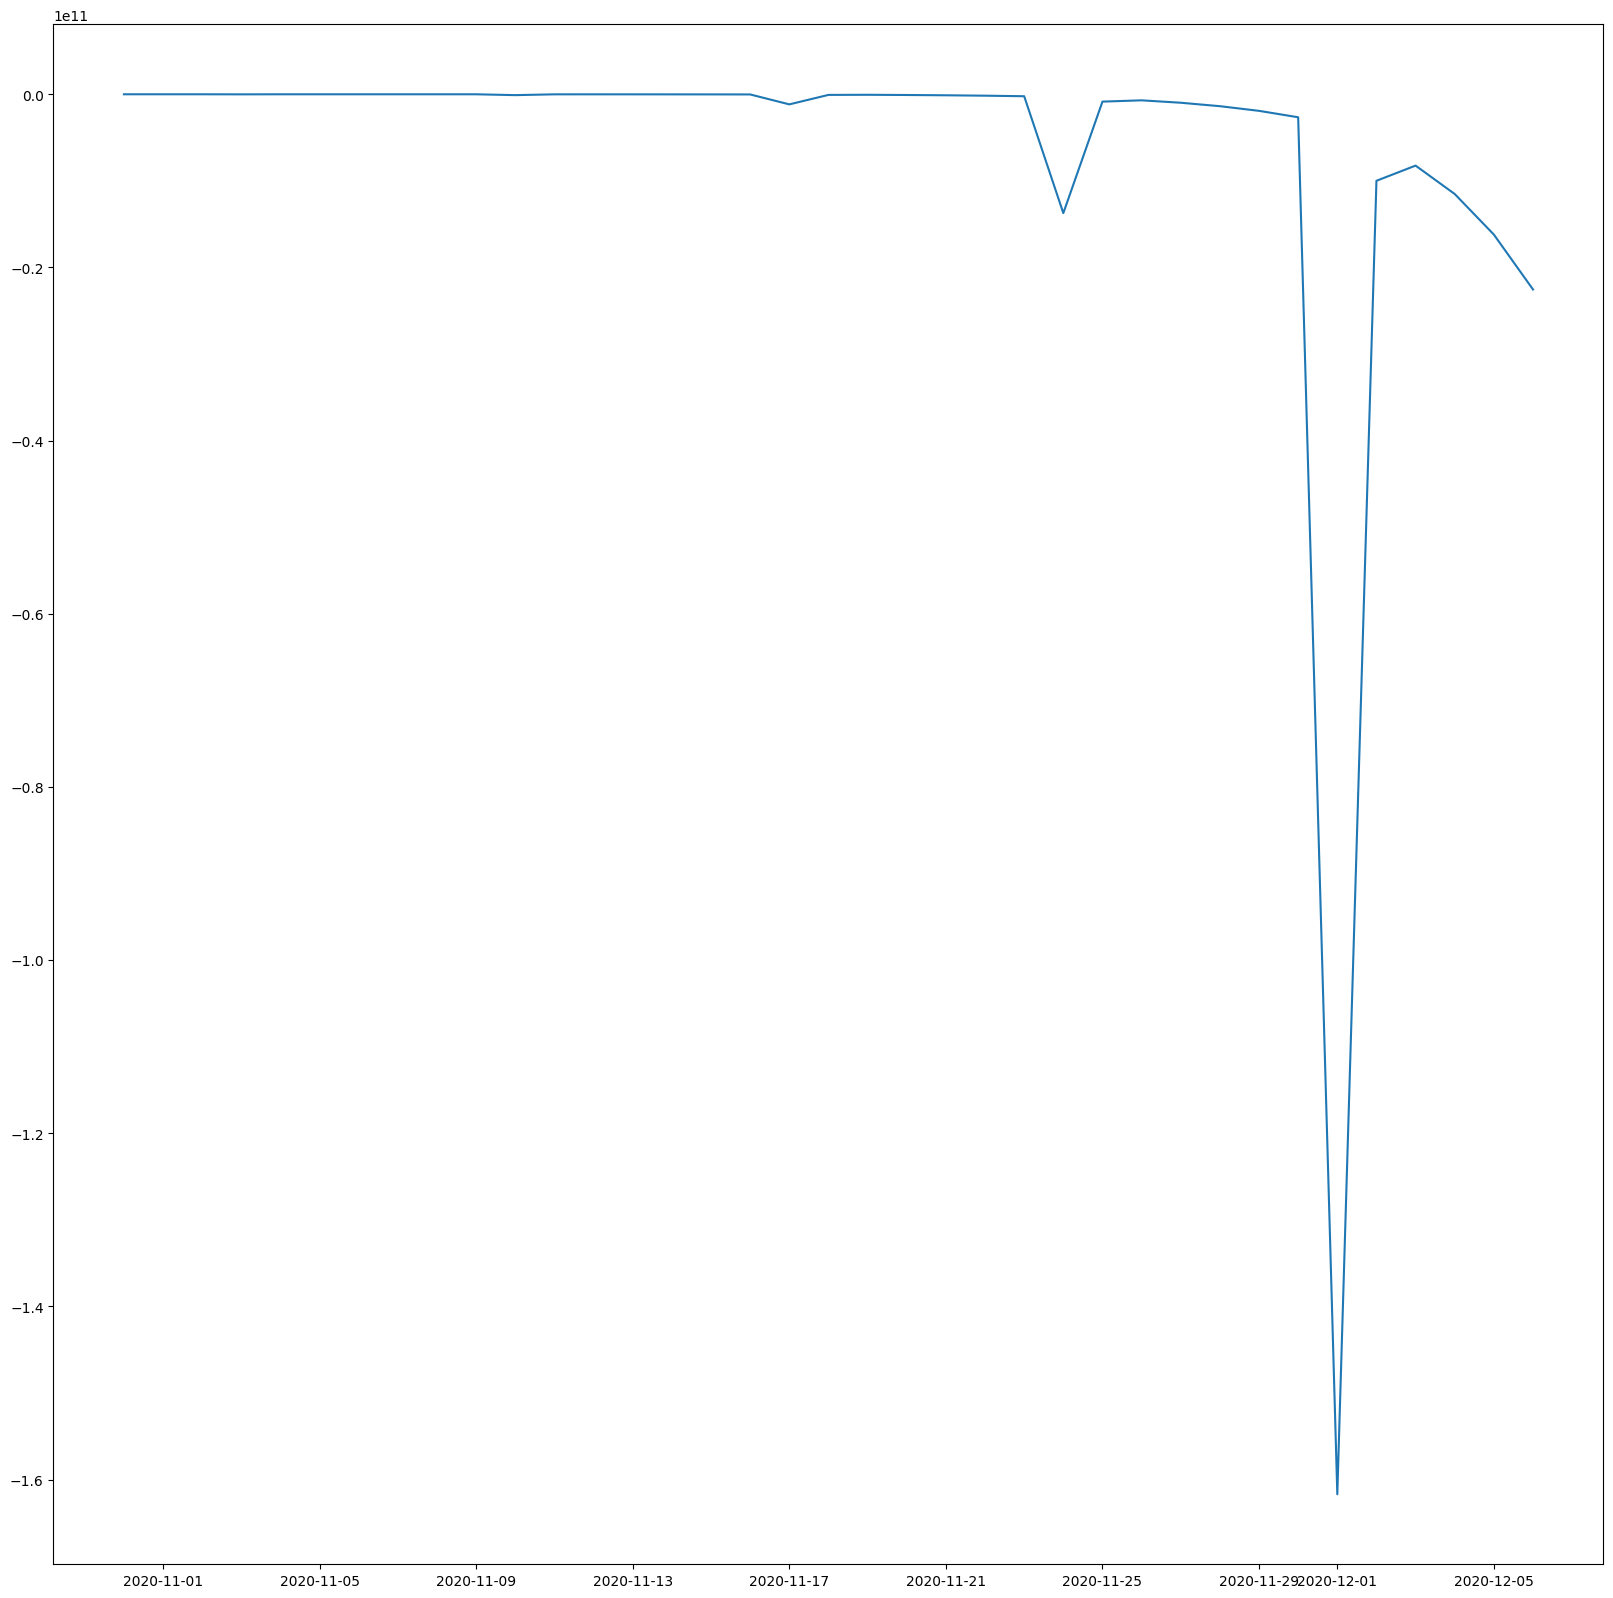

In [170]:
fig = plt.figure(figsize=(20, 20))
plt.plot(TES_Multiplicative_residuals)
plt.show()

### residual q-q plot for to check model performance 

<Figure size 2000x2000 with 0 Axes>

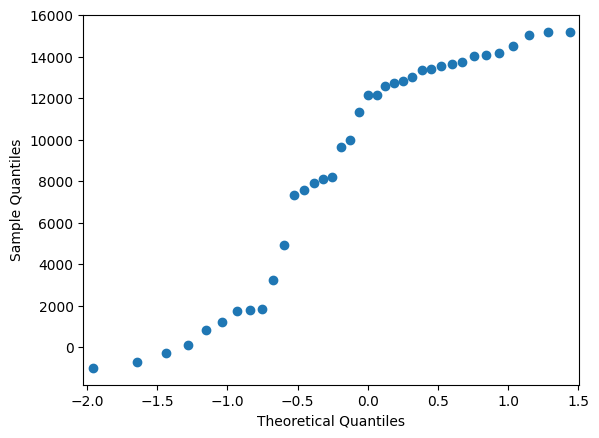

In [189]:
# Double Exponential Smoothing 

fig = plt.figure(figsize=(20, 20))
qqplot(DES_residuals,line="s");

<Figure size 2000x2000 with 0 Axes>

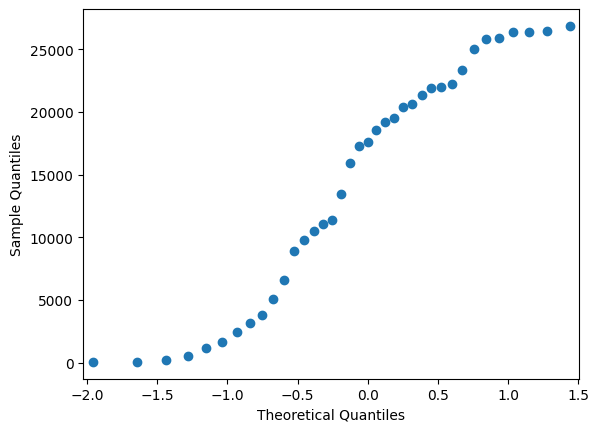

In [187]:
# Triple Exponential Smoothing [Additive Model]

fig = plt.figure(figsize=(20, 20))
qqplot(TES_Additive_residuals,line="s");

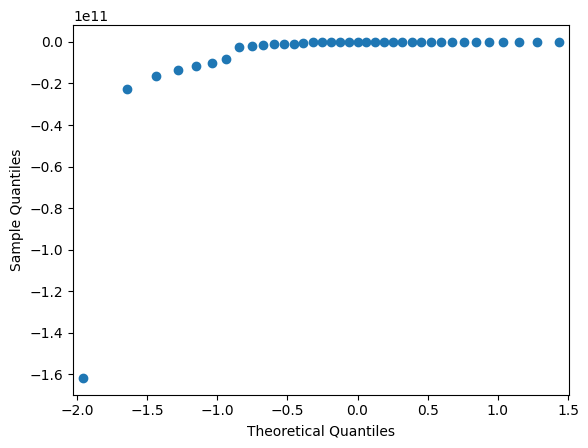

In [172]:
# Triple Exponential Smoothing [Multiplicative Model]

qqplot(TES_Multiplicative_residuals,line="s");

### By comparing MAPE score of Double exponential smoothing and Triple exponential Smoothing I would say Double exponential smoothing performs better and MAPE / Residual score are low when compare to Triple exponential smoothing